## Imports

In [1]:
import multiprocessing
import os
import pickle
import time

import energyflow as ef
from energyflow.datasets import mod
import matplotlib.pyplot as plt
import numpy as np

import modplot
import utils

## Load MOD Datasets

In [2]:
# make selections (consider amount = 0.01 for quick testing)
ptmin, ptmax = 375, 425
absetamax = '1.9'
amount = 1.0
specs = [(ptmin, '<= corr_jet_pts<', ptmax), 'abs_jet_eta < {}'.format(absetamax), 'quality >= 2']
save_plots = False

# use this if you've previously selected custom datasets
path = '~/.energyflow/'
preselected = True

In [3]:
if not preselected:
    cms = mod.load(*specs, dataset='cms', amount=amount)
    sim = mod.load(*specs, dataset='sim', amount=amount, store_gens=False)
    gen = mod.load(*specs, dataset='gen', amount=amount)

else:
    
    # make sure the path points to where you saved the custom datasets
    fullpath = os.path.join(os.path.expanduser(path), 'datasets/CMS2011AJets')
    cms = mod.MODDataset('cms/CMS_Jet300_pT375-infGeV', *specs, path=fullpath)
    sim = mod.MODDataset('sim/SIM_Jet300_pT{}-{}GeV'.format(ptmin, ptmax), *specs, 
                         path=fullpath, store_gens=False)
    gen = mod.MODDataset('sim/GEN_pT{}-{}GeV'.format(ptmin, ptmax), *specs, path=fullpath)    

## Observables

In [4]:
obs = {'Neutral_PFC_pTs': {'opts': {'which': 'neutral'}},
       'Charged_PFC_pTs': {'opts': {'which': 'charged'}},
       'Charged_PFC_pTs_CHS': {'opts': {'which': 'charged', 'chs': True}}}

# iterate over observables
start = time.time()
for ob_name,ob in obs.items():
    
    opts = ob['opts']
    
    # cms events
    cms_vals, cms_weights = [], []
    for pfcs,w in zip(cms.particles, cms.weights):
        pts = pfcs[utils.filter_particles(pfcs, **opts),cms.pt]
        cms_vals.append(pts)
        cms_weights.append(len(pts)*[w])
        
    ob['cms_values'] = np.concatenate(cms_vals)
    ob['cms_weights'] = np.concatenate(cms_weights)
    print(ob_name, 'CMS done in {:.3f}s'.format(time.time() - start))
        
    # sim events
    sim_vals, sim_weights = [], []
    for pfcs,w,pt,npv in zip(sim.particles, sim.weights, sim.corr_jet_pts, sim.npvs):
        pts = pfcs[utils.filter_particles(pfcs, **opts),sim.pt]
        sim_vals.append(pts)
        sim_weights.append(len(pts)*[w*utils.sim_factors(pt, npv)])
        
    ob['sim_values'] = np.concatenate(sim_vals)
    ob['sim_weights'] = np.concatenate(sim_weights)
    print(ob_name, 'SIM done in {:.3f}s'.format(time.time() - start))
    
    # gen events
    if 'CHS' in ob_name:
        ob['gen_values'] = obs['Charged_PFC_pTs']['gen_values']
        ob['gen_weights'] = obs['Charged_PFC_pTs']['gen_weights']
    else:
        gen_vals, gen_weights = [], []
        for gens,w,pt in zip(gen.particles, gen.weights, gen.jet_pts):
            pts = gens[utils.filter_particles(gens, **opts),gen.pt]
            gen_vals.append(pts)
            gen_weights.append(len(pts)*[w*utils.gen_factors(pt)])
            
        ob['gen_values'] = np.concatenate(gen_vals)
        ob['gen_weights'] = np.concatenate(gen_weights)
        print(ob_name, 'GEN done in {:.3f}s'.format(time.time() - start))
        
fp = os.path.join(utils.DATAPATH, 'plotdata', 'PFCpTSpectra_{}-{}GeV.pickle'.format(ptmin, ptmax))
with open(fp, 'wb') as f:
    pickle.dump(obs, f)

Neutral_PFC_pTs CMS done in 24.104s
Neutral_PFC_pTs SIM done in 102.389s
Neutral_PFC_pTs GEN done in 176.824s
Charged_PFC_pTs CMS done in 207.122s
Charged_PFC_pTs SIM done in 308.375s
Charged_PFC_pTs GEN done in 399.663s
Charged_PFC_pTs_CHS CMS done in 434.754s
Charged_PFC_pTs_CHS SIM done in 549.160s


In [5]:
fp = os.path.join(utils.DATAPATH, 'plotdata', 'PFCpTSpectra_{}-{}GeV.pickle'.format(ptmin, ptmax))

obs_zoom = np.load(fp, allow_pickle=True)
obs = np.load(fp, allow_pickle=True)

In [6]:
obs['Neutral_PFC_pTs'].update({
    'nbins': 50,
    'xlabel': r'Neutral PFC Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 500), 'ylim': (10.**-8, 10.**1), 'ylim_ratio': (0, 2),
    'xtick_step': 100, 'ytick_step': None, 'ytick_ratio_step': 0.5,
    'tx': 44.4, 'ty': 252,
    'line_0': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_1': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_2': None
})

obs['Charged_PFC_pTs'].update({
    'nbins': 50,
    'xlabel': r'Charged PFC Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 500), 'ylim': (10**-8, 10.**1), 'ylim_ratio': (0.5, 1.75),
    'xtick_step': 100, 'ytick_step': None, 'ytick_ratio_step': 0.25,
    'tx': 44.4, 'ty': 252,
    'line_0': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_1': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_2': None
})

obs['Charged_PFC_pTs_CHS'].update({
    'nbins': 50,
    'xlabel': r'Charged PFC Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 500), 'ylim': (10.**-8, 10.**1), 'ylim_ratio': (0.5, 1.75),
    'xtick_step': 100, 'ytick_step': None, 'ytick_ratio_step': 0.25,
    'tx': 44.4, 'ty': 252,
    'line_0': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_1': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_2': 'CHS',
})

obs_zoom['Neutral_PFC_pTs'].update({
    'nbins': 50,
    'xlabel': r'Neutral PFC Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 5), 'ylim': (0, 6), 'ylim_ratio': (0.5, 1.75),
    'xtick_step': 1, 'ytick_step': 1, 'ytick_ratio_step': 0.25,
    'tx': 44, 'ty': 252,
    'line_0': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_1': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_2': None
})

obs_zoom['Charged_PFC_pTs'].update({
    'nbins': 50,
    'xlabel': r'Charged PFC Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 5), 'ylim': (0, 4), 'ylim_ratio': (0.25, 1.5),
    'xtick_step': 1, 'ytick_step': 1, 'ytick_ratio_step': 0.25,
    'tx': 44, 'ty': 252,
    'line_0': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_1': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_2': None
})

obs_zoom['Charged_PFC_pTs_CHS'].update({
    'nbins': 50,
    'xlabel': r'Charged PFC Transverse Momentum $p_T$ [GeV]',
    'ylabel': 'Differential Cross Section [nb/GeV]',
    'xlim': (0, 5), 'ylim': (0, 2), 'ylim_ratio': (0.5, 1.5),
    'xtick_step': 1, 'ytick_step': 0.5, 'ytick_ratio_step': 0.25,
    'tx': 44, 'ty': 252,
    'line_0': r'AK5 Jets, $|\eta^{\rm jet}|<1.9$',
    'line_1': r'$p_T^{\rm jet}\in' + '[{},{}]$ GeV'.format(ptmin, ptmax),
    'line_2': 'CHS',
})

## Histograms

In [7]:
density = False
reg = 10**-30

hists, errs = {}, {}
for key,ob in obs.items():
    
    start = time.time()
    
    # get bins
    bins = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    step = bins[1] - bins[0]
    
    # CMS
    cms_hist, cms_errs, _ = modplot.calc_hist(ob['cms_values'], bins=bins, 
                                              weights=ob['cms_weights'], density=density)
    if not density:
        cms_hist /= step
        cms_errs /= step
    hists[key+'_cms'], errs[key+'_cms'] = cms_hist, cms_errs

    # SIM
    sim_hist, sim_errs, _ = modplot.calc_hist(ob['sim_values'], bins=bins,
                                              weights=ob['sim_weights'], density=density)
    if not density:
        sim_hist /= step
        sim_errs /= step
    hists[key+'_sim'], errs[key+'_sim'] = sim_hist, sim_errs
    
    # GEN
    gen_hist, gen_errs, _ = modplot.calc_hist(ob['gen_values'], bins=bins,
                                              weights=ob['gen_weights'], density=density)
    if not density:
        gen_hist /= step
        gen_errs /= step
    hists[key+'_gen'], errs[key+'_gen'] = gen_hist, gen_errs
    
    print('Calculated hists for {} in {:.3f}s'.format(key, time.time() - start))
    
fp = os.path.join(utils.DATAPATH, 'plotdata', 'PFCpTSpectraHists_{}-{}GeV.pickle'.format(ptmin, ptmax))
with open(fp, 'wb') as f:
    pickle.dump({'hists': hists, 'errs': errs}, f)

Calculated hists for Neutral_PFC_pTs in 27.546s
Calculated hists for Charged_PFC_pTs in 31.965s
Calculated hists for Charged_PFC_pTs_CHS in 27.431s


In [8]:
density = False
reg = 10**-30

hists_zoom, errs_zoom = {}, {}
for key,ob in obs_zoom.items():
    
    start = time.time()
    
    # get bins
    bins = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    step = bins[1] - bins[0]
    
    # CMS
    cms_hist, cms_errs, _ = modplot.calc_hist(ob['cms_values'], bins=bins, 
                                              weights=ob['cms_weights'], density=density)
    if not density:
        cms_hist /= step
        cms_errs /= step
    hists_zoom[key+'_cms'], errs_zoom[key+'_cms'] = cms_hist, cms_errs

    # SIM
    sim_hist, sim_errs, _ = modplot.calc_hist(ob['sim_values'], bins=bins,
                                              weights=ob['sim_weights'], density=density)
    if not density:
        sim_hist /= step
        sim_errs /= step
    hists_zoom[key+'_sim'], errs_zoom[key+'_sim'] = sim_hist, sim_errs
    
    # GEN
    gen_hist, gen_errs, _ = modplot.calc_hist(ob['gen_values'], bins=bins,
                                              weights=ob['gen_weights'], density=density)
    if not density:
        gen_hist /= step
        gen_errs /= step
    hists_zoom[key+'_gen'], errs_zoom[key+'_gen'] = gen_hist, gen_errs
    
    print('Calculated hists for {} in {:.3f}s'.format(key, time.time() - start))
    
fp = os.path.join(utils.DATAPATH, 'plotdata', 'PFCpTSpectraHistsZoom_{}-{}GeV.pickle'.format(ptmin, ptmax))
with open(fp, 'wb') as f:
    pickle.dump({'hists': hists_zoom, 'errs': errs_zoom}, f)

Calculated hists for Neutral_PFC_pTs in 37.123s
Calculated hists for Charged_PFC_pTs in 41.188s
Calculated hists for Charged_PFC_pTs_CHS in 41.838s


## Plots

In [9]:
fp = os.path.join(utils.DATAPATH, 'plotdata', 'PFCpTSpectraHists_{}-{}GeV.pickle'.format(ptmin, ptmax))
f = np.load(fp, allow_pickle=True)
hists, errs = f['hists'], f['errs']

fp = os.path.join(utils.DATAPATH, 'plotdata', 'PFCpTSpectraHistsZoom_{}-{}GeV.pickle'.format(ptmin, ptmax))
f = np.load(fp, allow_pickle=True)
hists_zoom, errs_zoom = f['hists'], f['errs']

reg = 10**-30

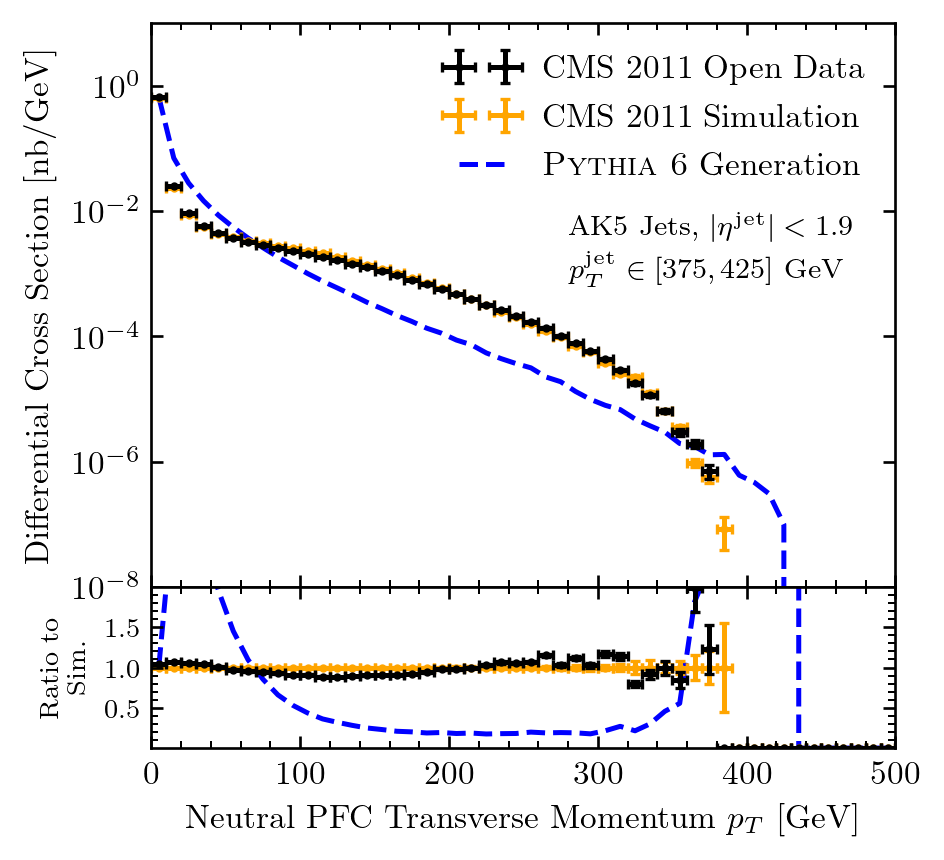

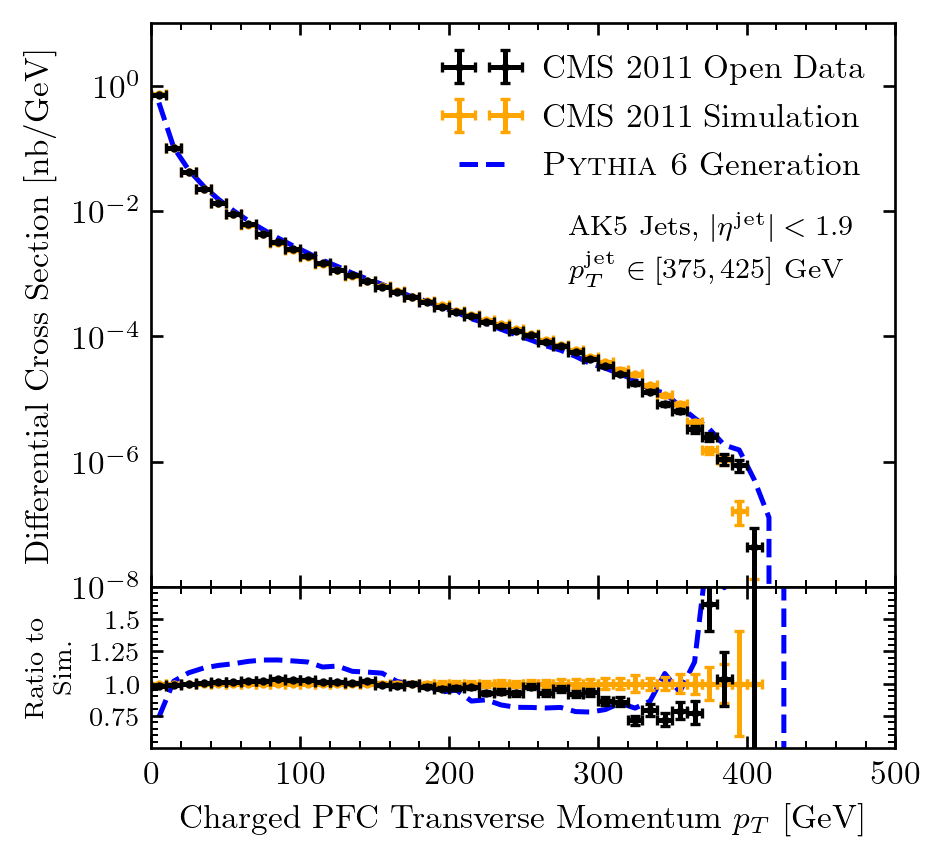

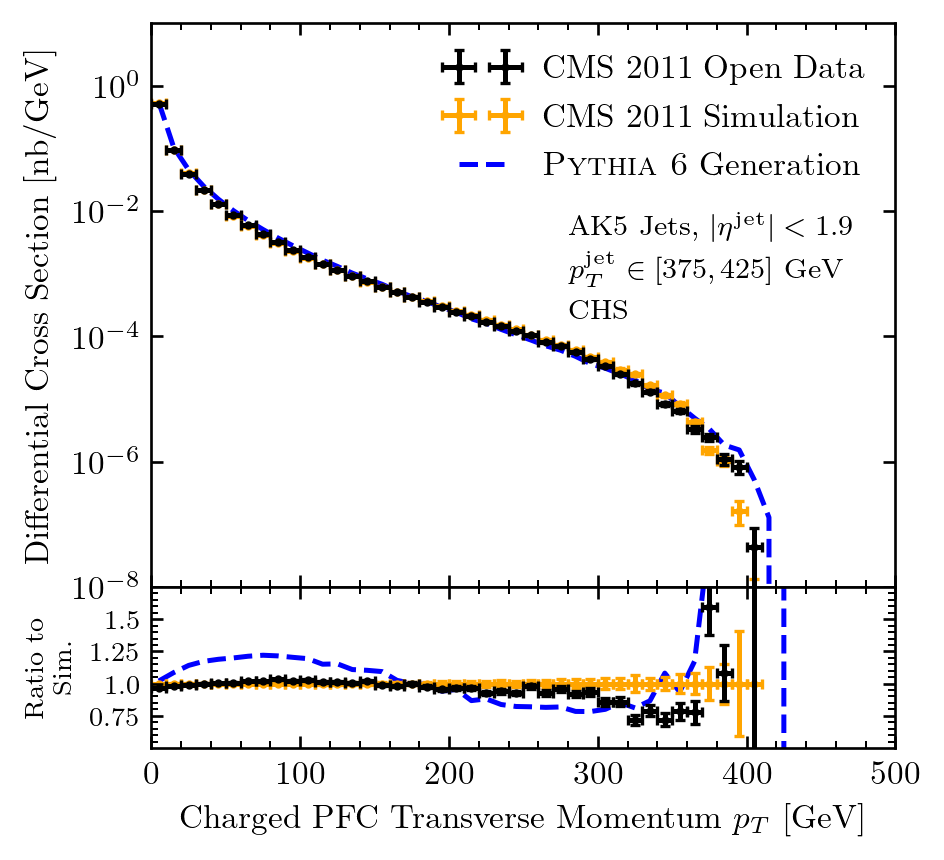

In [10]:
for key,ob in obs.items():

    # get axes in MOD plot format
    fig, axes = modplot.axes(ratio_plot=True, **ob)
    
    axes[0].set_yscale('log')

    # get bins
    bins = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    midbins, step = (bins[1:] + bins[:-1])/2, (bins[1] - bins[0])

    # get hists
    cms_hist, cms_errs = hists[key+'_cms'], errs[key+'_cms']
    sim_hist, sim_errs = hists[key+'_sim'], errs[key+'_sim']  
    gen_hist, gen_errs = hists[key+'_gen'], errs[key+'_gen']
    
    # CMS
    axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=2)
    axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2,
                     yerr=cms_errs/(sim_hist+reg), **modplot.cms_style(), zorder=2)

    # SIM
    axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=1)
    axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2,
                     yerr=sim_errs/(sim_hist+reg), **modplot.sim_style(), zorder=1)
    
    # GEN
    axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
    axes[1].plot(midbins, gen_hist/(sim_hist + reg), **modplot.gen_style(), zorder=0)
        
    # additional plot modifications
    modplot.stamp(0.56, 0.64, ax=axes[0], line_0=ob['line_0'], line_1=ob['line_1'], line_2=ob['line_2'])
    modplot.legend(ax=axes[0], order=[1,2,0])
    
    # save plot
    if save_plots:
        modplot.save(fig, key + '_{}-{}GeV'.format(ptmin, ptmax), 
                     tx=ob['tx'], ty=ob['ty'], out_plots_dir='../plots/PFCpTs')
    fig.show()

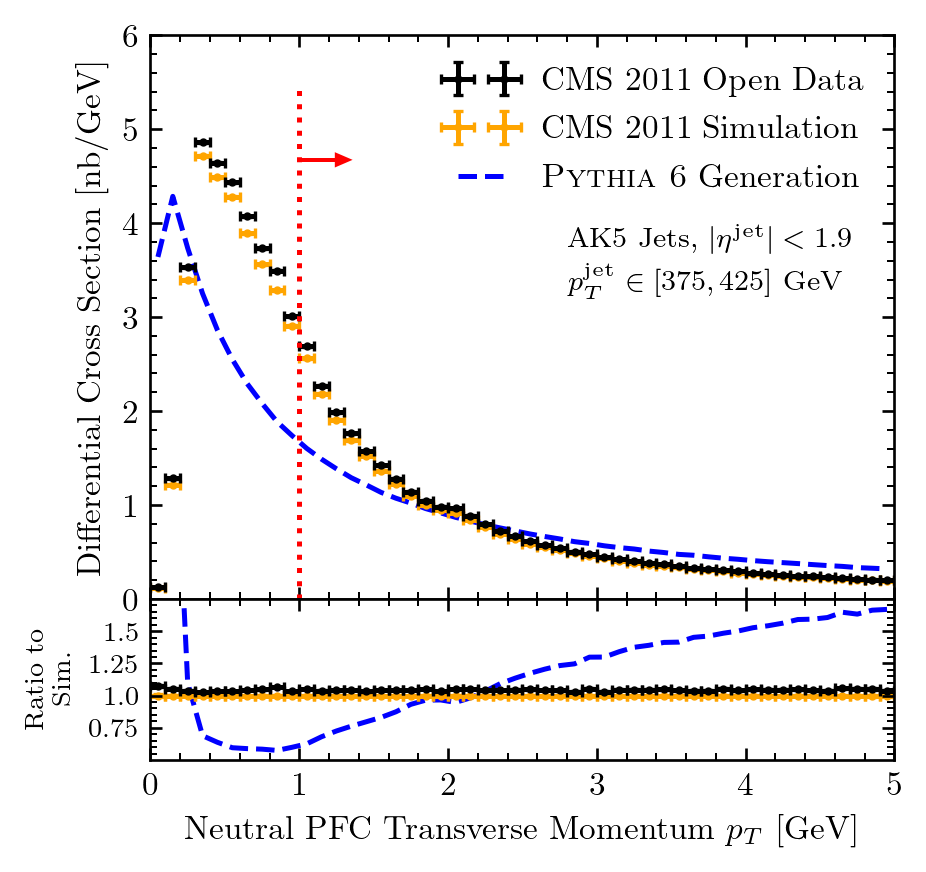

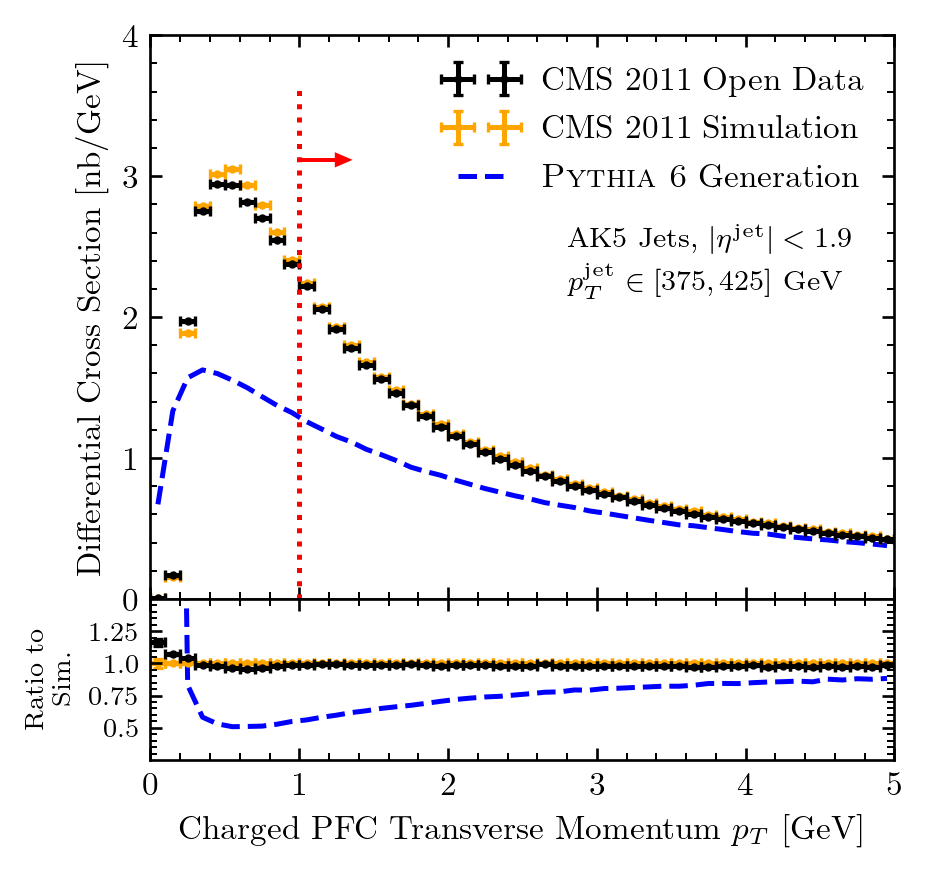

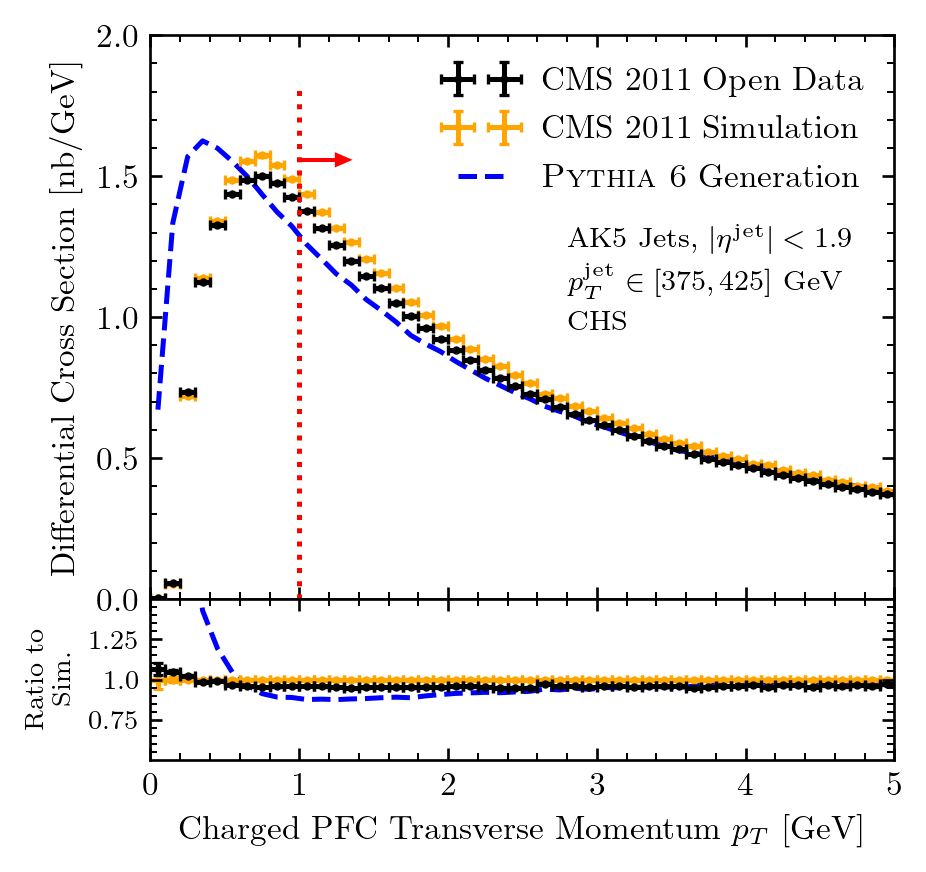

In [11]:
# zoomed plot settings
for key,ob in obs_zoom.items():

    # get axes in MOD plot format
    fig, axes = modplot.axes(ratio_plot=True, **ob)

    # get bins
    bins = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    midbins, step = (bins[1:] + bins[:-1])/2, (bins[1] - bins[0])

    # get hists
    cms_hist, cms_errs = hists_zoom[key+'_cms'], errs_zoom[key+'_cms']
    sim_hist, sim_errs = hists_zoom[key+'_sim'], errs_zoom[key+'_sim']  
    gen_hist, gen_errs = hists_zoom[key+'_gen'], errs_zoom[key+'_gen']
    
    # CMS
    axes[0].errorbar(midbins, cms_hist, xerr=step/2, yerr=cms_errs, **modplot.cms_style(), zorder=2)
    axes[1].errorbar(midbins, cms_hist/(sim_hist + reg), xerr=step/2,
                     yerr=cms_errs/(sim_hist+reg), **modplot.cms_style(), zorder=2)

    # SIM
    axes[0].errorbar(midbins, sim_hist, xerr=step/2, yerr=sim_errs, **modplot.sim_style(), zorder=1)
    axes[1].errorbar(midbins, sim_hist/(sim_hist+reg), xerr=step/2,
                     yerr=sim_errs/(sim_hist+reg), **modplot.sim_style(), zorder=1)
    
    # GEN
    axes[0].plot(midbins, gen_hist, **modplot.gen_style(), zorder=0)
    axes[1].plot(midbins, gen_hist/(sim_hist + reg), **modplot.gen_style(), zorder=0)
        
    # additional plot modifications
    modplot.stamp(0.56, 0.64, ax=axes[0], line_0=ob['line_0'], line_1=ob['line_1'], line_2=ob['line_2'])
    modplot.legend(ax=axes[0], order=[1,2,0])

    # arrows for the pT PFC cuts
    yline = 0.91*ob['ylim'][1]
    axes[0].plot([1, 1], [0, yline], ':', color='red')
    axes[0].arrow(1, yline*0.856, 0.25, 0, head_width=0.02*yline, head_length=0.08, edgecolor=None, color='red')
    
    # save plot
    if save_plots:
        modplot.save(fig, key + '_Zoom_{}-{}GeV'.format(ptmin, ptmax),
                     tx=ob['tx'], ty=ob['ty'], out_plots_dir='../plots/PFCpTs')
    fig.show()